# Lab 4. Word embeddings.

Для начала, как всегда, всевозможные приготовления к работе. Использовать будем заранее предобработанные текты из трёх википедий — английской, русской и simple. Большая часть лабы выполнялась на full, но переключение на любую другую производится заменой единственного параметра (не то чтобы это было неочевидно, впрочем).

In [64]:
import collections
import math
import os
import random
from datetime import datetime
from itertools import accumulate
import itertools
from IPython.display import clear_output
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import tensorflow as tf
import pickle
import stop_words
import regex as re
import sys

import scipy
from scipy import sparse

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances
import sklearn.decomposition
from sklearn.manifold import TSNE

wikis = {
    'full': {
        'lang': 'en',
        'counter_file': 'full/counter',
        'wiki_file': '/Users/akiiino/Documents/Wiki/full/processed.dat',
        'vocab_size': 100000,
        'W2V_embed_file': 'full/W2V_embed.npy',
        'LSA_embed_file': 'full/LSA_embed.npy',
        'LSA_TfIdf_file': 'full/LSA_TfIdf.npz',
        'LSA_vocab_file': 'full/LSA_vocab',
        'glove_coocc_file': 'full/glove_coocc.npz',
        'glove_embed_file': 'full/glove_embed.npy'
    },
    'simple': {
        'lang': 'en',
        'counter_file': 'simple/counter',
        'wiki_file': '/Users/akiiino/Documents/Wiki/simple/processed.dat',
        'vocab_size': 50000,
        'W2V_embed_file': 'simple/W2V_embed.npy',
        'LSA_embed_file': 'simple/LSA_embed.npy',
        'LSA_TfIdf_file': 'simple/LSA_TfIdf.npz',
        'LSA_vocab_file': 'simple/LSA_vocab',
        'glove_coocc_file': 'simple/glove_coocc.npz',
        'glove_embed_file': 'simple/glove_embed.npy'
    },
    'ru': {
        'lang': 'ru',
        'counter_file': 'ru/counter',
        'wiki_file': '/Users/akiiino/Documents/Wiki/ru/processed.dat',
        'vocab_size': 100000,
        'W2V_embed_file': 'ru/W2V_embed.npy',
        'LSA_embed_file': 'ru/LSA_embed.npy',
        'LSA_TfIdf_file': 'ru/LSA_TfIdf.npz',
        'LSA_vocab_file': 'ru/LSA_vocab',
        'glove_coocc_file': 'ru/glove_coocc.npz',
        'glove_embed_file': 'ru/glove_embed.npy'
    },
}

def load_wiki(wiki):
    global LANG
    global WIKI_FILE
    global VOCAB_SIZE
    global LSA_TFIDF_FILE
    global LSA_EMBED_FILE
    global LSA_VOCAB_FILE
    global W2V_COUNT_FILE
    global W2V_EMBED_FILE
    global GLOVE_COOCC_FILE
    global GLOVE_EMBED_FILE
    LANG           = wikis[wiki]['lang']
    WIKI_FILE      = wikis[wiki]['wiki_file']
    VOCAB_SIZE     = wikis[wiki]['vocab_size']
    LSA_TFIDF_FILE = wikis[wiki]['LSA_TfIdf_file']
    LSA_EMBED_FILE = wikis[wiki]['LSA_embed_file']
    LSA_VOCAB_FILE = wikis[wiki]['LSA_vocab_file']
    W2V_COUNT_FILE = wikis[wiki]['counter_file']
    W2V_EMBED_FILE = wikis[wiki]['W2V_embed_file']
    GLOVE_COOCC_FILE = wikis[wiki]['glove_coocc_file']
    GLOVE_EMBED_FILE = wikis[wiki]['glove_embed_file']

load_wiki("full")

Всё ещё вспомогательные вещи. Генератор статей из файла: читает статьи, нормализует, если нужно, переводит в индексы слов, возвращает.

In [2]:
def normalize(text, punct, stops):
    text = text.lower()     # case
    text = punct.sub("", text)      # punctuation
    text = (word for word in text.split() if word not in stops)       # stop words
    return text

    
def wiki_gen(filename, trans=None, chunk=1024, one_pass=False, LSA=False):    
    read = 0
    cache = 0
    
    stops = set(stop_words.get_stop_words(LANG))
    punct = re.compile(r"\p{P}+")
    with open(filename) as wiki_file:
        while True:
            lines = " ".join(line for line in wiki_file.readlines(chunk))
            read += len(lines)

            if read > cache + 2**26:
                print('pulling... total {} MB\r'.format(read//2**20), end="")
                cache = read

            if not lines:
                if one_pass:
                    return
                wiki_file.seek(0)
                print("Starting over...")
                continue

            lines = normalize(lines, punct, stops)

            if trans:
                lines = (trans[word] if word in trans else 0 for word in lines)
            if not LSA:
                yield lines
            else:
                yield " ".join(lines)

## LSA

### **Задание**
**1**.  Вычислите $X$ понравившимся способом (возможно, стоит использовать разреженную матрицу).

**2**. Обучите представления слов при $k = 128$ на своем корпусе.

Обучение устроено просто: пайплайн из `sklearn`'ового `TfidfVectorizer` для построения самой матрицы $X$, после чего Truncated SVD в виде `scipy.sparse.linalg.svds`.

In [3]:
if not os.path.exists(LSA_EMBED_FILE):
    vectorizer = TfidfVectorizer(min_df=3, max_df=0.7, stop_words=stop_words.get_stop_words(LANG))
    tfidf = vectorizer.fit_transform(wiki_gen(WIKI_FILE, chunk=1, one_pass=True, LSA=True)).T
    np.savez(LSA_TFIDF_FILE, tfidf)

    print("Tf-Idf done                ")
    
    svd = sklearn.decomposition.TruncatedSVD(n_components=128)
    
    LSA_embeds = svd.fit_transform(tfidf)
    np.save(LSA_EMBED_FILE, LSA_embeds)

    LSA_vocab = vectorizer.vocabulary_

    with open(LSA_VOCAB_FILE, 'wb') as vocab_file:
        pickle.dump(LSA_vocab, vocab_file)
else:
    LSA_embeds = np.load(LSA_EMBED_FILE)
    with open(LSA_VOCAB_FILE, 'rb') as vocab_file:
        LSA_vocab = pickle.load(vocab_file)

При этом после вычисления всё сохраняется на диск, чтобы лишний раз не считать, если понадобится снова.

**3**. Реализуйте поиск k-ближайших соседей для Евклидовой меры в 128-мерном пространстве .

Скелет для нахождения соседей: по вектору находим ближайшие слова; сложность линейная, т.к. использован `argpartition`. Сам вектор может быть получен как напрямую из слова, так и, например, сложениями и вычитаниями других векторов.

In [4]:
def closest_to_vec(vec, embeds, rev_vocab, metric_name='euclid', count=10, with_dists=False):
        metrics = {
            'euclid': euclidean_distances,
            'cosine': cosine_similarity,
            'manhattan': manhattan_distances
        }
        
        metric = metrics[metric_name]
        
        dists = metric(
                [vec],
                embeds
        )[0]
        
        if metric_name == "cosine":
                closest_indexes = dists.argpartition(range(-count, 0))[-1:-count-1:-1]
        else:
                closest_indexes = dists.argpartition(range(0, count))[:count]

        if with_dists:
            return list(zip(dists[closest_indexes], [rev_vocab.get(x, "") for x in closest_indexes]))
        else:
            return [rev_vocab.get(x, "") for x in closest_indexes]


Сам поиск по словам:

In [5]:
def closest_words(word, embeds, vocab, rev_vocab=None, metric='euclid', count=10, with_dists=False):
    if rev_vocab == None:
        rev_vocab = {v: k for k, v in vocab.items()}
        
    return closest_to_vec(embeds[vocab[word]], embeds, rev_vocab, metric, count, with_dists)

In [6]:
words = ["field", "directed", "financial", "road", "provides", "player", "2011", "edition", "battle", "ended", "son", "least", "mexico", "male", "medal", "big", "central", "according", "km", "year", "rights", "george", "founded", "tournament", "instead", "movie", "29", "system", "york", "win"]

**4**. Найдите 10 ближайших представлений к 30 словам, которые выбрали сами. Попытайтесь сделать так, чтобы примеры были интересными.

In [7]:
for word in words:
    print(word.ljust(10), ":", " ".join(closest_words(word, LSA_embeds, LSA_vocab)[1:]))

field      : advanced fields holds capacity led physics leading addition selected
directed   : starring drama movie comedy stars silent documentary roles feature
financial  : investment exchange fund billion insurance employees finance corporate ceo
road       : route uci sr along intersection junction roads highway cyclist
provides   : provide access providing quality funding standards resources provided environment
player     : players professional playing former retired level seasons career draft
2011       : 2012 2009 2013 2010 2007 2008 announced 2005 2001
edition    : qualifying tournaments editions classic edited hard titles copies titled
battle     : battalion corps troops forces brigade infantry artillery men cavalry
ended      : saw nine failed start despite twice suffered decided coming
son        : daughter death henry father wife died married sir brother
least      : almost referred longer strong outside caused likely either fact
mexico     : mexican el santa juan del josé

Есть несколько интересных вещей. 
Например, следующее:
- То, как сгруппированы числа (а особенно то, что рядом находятся числа схожей величины);
- то, что рядом со словом "york" находятся также и "jersey", и "new", с которого обычно начинаются оба;
- то, как "edition" почему-то близко к терминам, относящимся к спорту (наверное?);
- male почему-то близко к weightlifter и weightlifting (значит, даже не случайность);
- то, как "central" явно встречается преимущественно в географическом контексте;

**5**. Проделайте то же самое для косинусной меры. Какой результат вам показался более интересным?


In [8]:
for word in words:
    print(word.ljust(10), ":", " ".join(closest_words(word, LSA_embeds, LSA_vocab, metric="cosine")[1:]))

field      : pseudofinite pbasis 192859 dugouts forcefree polywells backstop fields bleacher
directed   : film crimedrama starring curtiz adventurecomedy remade romanticdrama thrillerdrama stagy
financial  : financing investment investing invest corporate brokering fund investments lending
road       : tjunction aroad a1173 singlecarriageway totsos a625 a1151 a226 b5020
provides   : providing provide tailored enhance resource uptodate servicebased feebased supports
player     : lastcard holosseum phosphos 10high enemiesin remotedetonation genergy toepen bimatrix
2011       : 2012 2009 2010 2013 cq1 mid2011 2007 announced 2008
edition    : editions garista 60page wellstuffed 40page 36page 44page 28page 24page
battle     : repulsing reinforcements repulsed skirmishes garrison fought recapturing surrender skirmish
ended      : struggled saw last overcame start slipped faltered picked eventual
son        : grandson daughter cousin fatherinlaw nephew granddaughter elder sons brotherinlaw
le

Тут вообще непонятно что происходит. Видимо, в длине векторов тоже естьь важная информация и лучше было всё же с евклидовой метрикой.

**6**. Предложите свою меру длины, проверьте, как она работает.

In [9]:
for word in words:
    print(word.ljust(10), ":", " ".join(closest_words(word, LSA_embeds, LSA_vocab, metric="manhattan")[1:]))

field      : analysis fields physics theory advanced physical applied mathematical laboratory
directed   : starring silent stars drama movie soundtrack pictures comedy composed
financial  : investment exchange insurance billion fund employees banking corporate finance
road       : route highway sr along intersection junction uci terminus near
provides   : provide access providing quality funding provided standards resources needs
player     : professional playing players level seasons draft retired currently fivb
2011       : 2012 2013 2009 2010 2008 2007 announced 2005 2014
edition    : editions qualifying tournaments edited publication authors publisher publishing issue
battle     : battalion troops forces corps brigade artillery cavalry infantry men
ended      : suffered failed saw despite missed dropped decided fell coming
son        : daughter married henry death wife father earl died lord
least      : likely almost difficult referred caused therefore remain might relatively
mexic

В целом, примерно как и в евклидовой метрике.

## Word2Vec

Сначала о теории:

### **Задание**

**1**. Как можно представить модель skip-gram в виде нейронной сети?

Тут практически нет отличий от CBOW. Два линейных слоя без нелинейности между ними, в конце --- softmax. На вход сеть принимает one-hot вектор размерности $W$, кодирующий центральное слово; на выходе --- вектор той же размерности, представляющий собой вероятности каждого слова.

**2**. Оцените сложность обучения skip-gram модели относительно параметров 
* $T$ - размер корпуса;
* $W$ - размер словаря;
* $c$ - радиус окна;
* $d$ - размерность представлений;

** Forward propagation:**

$(d \times W) \cdot (W \times 1); (W \times d) \cdot (d \times 1) \implies O(WD) + O(WD) = O(WD)$;

Softmax --- ещё дополнительно линейное (от $W$) время. Итого $O(WD)$ --- ничего страшного.

** Backpropagation:**
    
Взятие производных функции ошибки --- $O(Wdc)$, т.к. мы берём производные по матрицам размера $O(Wd)$, и наш размер контекста --- $c$. При этом нам надо это будет сделать $O(T)$ раз --- для каждого батча.

Итого --- $O(TWdc)$

Снова вспомогательные штуки: функция для составления словаря. В `W2V_COUNT_FILE` сохраняются все частоты слов, в `counter` --- только верхние `VOCAB_SIZE` слов (включая `UNK`):

In [10]:
def get_vocab(wiki_file, counter_file, vocab_size=None):
    if not os.path.exists(counter_file):
        counter = collections.Counter()

        for chunk in wiki_gen(wiki_file, chunk=2**26, one_pass=True):
            counter.update(chunk)
        
        with open(counter_file, 'wb') as file:
            pickle.dump(counter, file)

    else:
        with open(counter_file, 'rb') as file:
            counter = collections.Counter(pickle.load(file))
    
                
    unk_count = sum(counter.values()) - sum(x[1] for x in counter.most_common(vocab_size-1))
    counter = dict([('UNK', unk_count)] + counter.most_common(vocab_size - 1))
    vocab = {word: num for num, (word, _) in enumerate(counter.items())}
    rev_vocab = {num: word for word, num in vocab.items()}
    return counter, vocab, rev_vocab

counter, w2v_vocab, w2v_rev_vocab = get_vocab(WIKI_FILE, W2V_COUNT_FILE, VOCAB_SIZE)

Батчи генерируются из скользящего окна шириной `skip_window`; из каждого окна берётся `num_skips` пар слов.

In [11]:
def w2v_batch_gen(wiki_file, batch_size, num_skips, skip_window):
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window

    gen = wiki_gen(wiki_file, w2v_vocab, 2**26, set(stop_words.get_stop_words(LANG)))
    
    pulled = 0
    buffer = collections.deque()

    while True:
        while len(buffer) < 2*skip_window + batch_size//num_skips:
            next_chunk = next(gen)
            buffer.extend(next_chunk)
        
        batch  = np.ndarray(shape=(batch_size),    dtype=np.int32)
        labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)

        span = 2 * skip_window + 1

        for i in range(batch_size // num_skips):
            target = skip_window
            available_targets = list(range(span))
            available_targets.remove(target)
            for j in range(num_skips):
                target = random.choice(available_targets)
                available_targets.remove(target)
                batch[i * num_skips + j] = buffer[skip_window]
                labels[i * num_skips + j, 0] = buffer[target]
            buffer.popleft()
        yield batch, labels

### **Задание**
1. Выберите понравивщуюся вам функцию потерь. Оцените сложность обучения для нее, сравните с простым softmax.
2. На основе оценки сложности определиться с количеством эпох, размера вектора $d$ = 256 будет достаточно. Определитесь с размером окна. Будьте готовы, что на большом корпусе обучение может длиться около суток.

Пользоваться будем NCE --- преимущественно из-за простоты реализации. Сложность обучения оценить легко: фактически, единственное существенное изменение (асимптотики, разумеется; сами алгоритмы отличаются существенно) заключается в том, что вместо прохода по всем $W$ словам, мы рассматриваем только $k$ cлучайных слов; итого сложность $O(Tcdk)$.

In [12]:
batch_size = 256
embedding_dim = 256
skip_window = 6
num_skips = 4
neg_samples = 100

w2v_graph = tf.Graph()
with w2v_graph.as_default():
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

    all_embeddings = tf.Variable(
        tf.random_uniform(
            [VOCAB_SIZE, embedding_dim],
            -1.0,
            1.0
        )
    )
    embed = tf.nn.embedding_lookup(all_embeddings, train_inputs)

    weights = tf.Variable(
        tf.truncated_normal(
            [VOCAB_SIZE, embedding_dim],
            stddev=1.0 / math.sqrt(embedding_dim)
        )
    )
    biases = tf.Variable(tf.zeros([VOCAB_SIZE]))

    loss = tf.reduce_mean(
        tf.nn.nce_loss(
            weights=weights,
            biases=biases,
            labels=train_labels,
            inputs=embed,
            num_sampled=neg_samples,
            num_classes=VOCAB_SIZE
        )
    )

    optimizer = tf.train.AdagradOptimizer(0.5).minimize(loss)

    init = tf.global_variables_initializer()

Экспериментальным путём выяснено, что десяти миллионов итераций достаточно, чтобы обучиться (по крайней мере до состояния, где заметных улучшений нет). Занимает это (у меня, по крайней мере) около восьми-девяти часов (надо бы, конечно, сделать две-три полные эпохи, но это очень уж долго. Может быть, потом). Девять часов --- это всё-таки немало, так что тут тоже есть возможность загружать и выгружать результаты.

**3**. Обучите skip-gram модель.

In [13]:
if not os.path.exists(W2V_EMBED_FILE):
    num_steps = 1000

    with tf.Session(graph=w2v_graph) as session:
        init.run()

        average_loss = 0
        batch_gen = w2v_batch_gen(WIKI_FILE, batch_size, num_skips, skip_window)
        for step in range(num_steps):
            try:
                for _ in range(10000):
                    batch_inputs, batch_labels = next(batch_gen)
                    feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

                    _, loss_val= session.run([optimizer, loss], feed_dict=feed_dict)

                    average_loss += loss_val


                clear_output()
                print("Time: {}; steps: {}; avg. loss: {}.".format(datetime.now().strftime("%H:%M:%S"), step*10000, average_loss/10000))
                average_loss = 0
                embeds = all_embeddings.eval()
                for i in range(10):
                    w = w2v_rev_vocab[random.randint(1, 150)]
                    print(w.ljust(10), ":", " ".join(closest_words(w, embeds, w2v_vocab, w2v_rev_vocab)[1:]))

            except KeyboardInterrupt:
                break

        if step > 10:
            w2v_embeds = all_embeddings.eval()
            np.save(W2V_EMBED_FILE, w2v_embeds)
else:
    w2v_embeds = np.load(W2V_EMBED_FILE)

**4**. Попробуйте снова найти ближайшие представления для тех 30 слов. Улучшился ли результат визуально? Попробуйте разные меры расстояния (евклидова, косинусная).

In [14]:
for word in words:
    print(word.ljust(10), ":", " ".join(closest_words(word, w2v_embeds, w2v_vocab)[1:]))

field      : fields however addition UNK well result recently whose thus
directed   : starring starred produced adaptation written film inspired movie collaboration
financial  : business investment however corporate fact legal economic finance despite
road       : near along nearby UNK highway lane route now way
provides   : providing provided provide allows offers includes requires gives addition
player     : players playing play game team latter played however UNK
2011       : 2010 2012 2013 2009 2014 2007 2008 2015 2006
edition    : editions version titled printed publication introduction featuring appear entitled
battle     : battles fought fighting captured allies fight combat actions soldiers
ended      : finally started start began continued however broke resulted saw
son        : daughter father wife brother cousin sons fathers grandson uncle
least      : nearly already indeed possibly less although however fact instance
mexico     : mexican spain possibly although however UNK 

Видно, что качество сильно улучшилось; вместо слов, которые относятся примерно к одной теме теперь рядом находятся слова, значащие примерно одно и то же; вместо всяких "founded" --- "university" и прочее, теперь тут "founded: --- "formed", "established"... "bought"... В общем, теперь смысла гораздо больше (что было ясно ещё из сложений-вычитаний).

**5**. Найдите ближайшие вектора для выражения v(king) - v(man) + v(women). Если модель обучена хорошо, то среди ближайших векторов должно быть представление v(queen). 


Функция для сложения-вычитания векторов:

In [15]:
def analogy(pos, neg, embeds, vocab, metric='euclid', count=10):
    pos_vec = [embeds[vocab[w]] if w in vocab else embeds[vocab["UNK"]] for w in pos]
    neg_vec = [embeds[vocab[w]] if w in vocab else embeds[vocab["UNK"]] for w in neg]
    
    rev_vocab = {v: k for k, v in vocab.items()}


    return [
        pair for pair in closest_to_vec(
            sum(pos_vec) - sum(neg_vec),
            embeds,
            rev_vocab,
            metric_name=metric,
            count=count,
            with_dists=True
        ) if pair[1] not in pos and pair[1] not in neg
    ]

Можно поэкспериментировать и посмотреть, что получится. Базовые примеры:

In [16]:
analogy(["king", "woman"], ["man"], w2v_embeds, w2v_vocab)

[(5.1323166, 'queen'),
 (5.7037077, 'kings'),
 (5.7156305, 'princess'),
 (5.7418556, 'daughter'),
 (5.8437057, 'wife'),
 (5.9265995, 'UNK'),
 (5.935421, 'son'),
 (5.9598231, 'similarly')]

**6**. На основе арифметических операций над представлениями предложите алгоритмы, которые
  * Для страны определяют столицу
  * Для компании определяют CEO
  * Для прилагательного определяют превосходную форму
  * Для слова определяют множественное число
  * Для слова находит его антоним

#1. Столицы:

In [17]:
def capital(countries):
    return [
        analogy(
            [country,
            "moscow", "seoul", "athens",],
            ["russia", "korea", "greece",],
            w2v_embeds,
            w2v_vocab
        )[0][1] for country in countries
    ]

countries = [
    "germany",
    "france",
    "japan",
    "spain",
    "canada",
    "greece",
    "albania",
    "afghanistan",
    "algeria",
    "norway",
    "india"
]
print("\n".join("\t".join(pair) for pair in zip(countries,capital(countries))))

germany	berlin
france	paris
japan	tokyo
spain	madrid
canada	montreal
greece	paris
albania	belgrade
afghanistan	chicago
algeria	paris
norway	oslo
india	chicago


Как видно, работает, но не всегда идеально (Афганистан, Чикаго, што?). Чем больше пар "страна --- столица" взято в качестве опоры --- тем лучше качество (но это только гипотеза, впрочем), но тем больше вопросов "А зачем вообще, если есть большая база столиц?".

Логично предположить, что на самом деле вектор "Москва" - "Россия" + "Сеул" - "Корея" + "Афины" - "Греция" в три раза больше "эталонного" сдвига между столицей и страной, однако если этот вектор поделить на три, всё только портится. Видать, не такое уж и векторное пространство.

#2. CEO:

In [18]:
def CEO(companies):
    return [
        analogy(
            ["zuckerberg", company],
            ["facebook"],
            w2v_embeds,
            w2v_vocab
        )[0][1] for company in companies
    ]

companies = [
    "apple",
    "sun",
    "oracle"
]
print("\n".join(" ".join(pair) for pair in zip(companies, CEO(companies))))

apple exception
sun latter
oracle apparently


Мда. Идея должна бы срaботать, но нужно нечеловеческое время на обучение и словарь побольше.

#3. Прилагательные:

In [19]:
def superlative(adjectives):
    return [
        analogy(
            ["fastest", adjective],
            ["fast"],
            w2v_embeds,
            w2v_vocab
        )[0][1] for adjective in adjectives
    ]

adjectives = [
    "dark",
    "big",
    "good",
    "sharp",
    "strange",
    "blue",
]
print("\n".join(" ".join(pair) for pair in zip(adjectives, superlative(adjectives))))

dark black
big biggest
good kind
sharp marked
strange worlds
blue red


О, работает! Почти... Смысл точно местами прослеживается.

#4. Множественное число:

In [20]:
def plural(nouns):
    return [
        analogy(
            ["boxes", noun],
            ["box"],
            w2v_embeds,
            w2v_vocab
        )[0][1] for noun in nouns
    ]

nouns = [
    "queen",
    "moose",
    "box",
    "chair",
    "glass",
]
print("\n".join(" ".join(pair) for pair in zip(nouns, plural(nouns))))

queen princess
moose easily
box rather
chair chairman
glass looking


Не очень что-то.

## GloVe

На большой вики строить --- можно состариться, а мне ещё и памяти не хватает. Переключимся на маленькую:

In [48]:
load_wiki("simple")
counter, glove_vocab, _ = get_vocab(WIKI_FILE, W2V_COUNT_FILE, VOCAB_SIZE)

In [22]:
def get_cooccur(vocab, skip_window=6):    
    if not os.path.exists(GLOVE_COOCC_FILE):
        mat = np.zeros((VOCAB_SIZE, VOCAB_SIZE), dtype=np.float32)  # scipy.sparse.lil_matrix((VOCAB_SIZE, VOCAB_SIZE), dtype=np.float32)
        text_gen = wiki_gen(WIKI_FILE, chunk=2**26, one_pass=True)

        buffer = collections.deque()
        pulled = 0

        stop = False
        i = 0
        while True:
            i+= 1;
            if i % 100000 == 0:
                print("{}\r".format(i), end="")
            while len(buffer) < skip_window + 1:
                try:
                    next_chunk = next(text_gen)
                except StopIteration:
                    stop = True
                    break
                buffer.extend(next_chunk)

            if stop:
                break

            for j in range(1, skip_window+1):
                mat[vocab.get(buffer[0], 0), vocab.get(buffer[j], 0)] += 1./j
                mat[vocab.get(buffer[j], 0), vocab.get(buffer[0], 0)] += 1./j
            buffer.popleft()
            
        mat = scipy.sparse.lil_matrix(mat)
        np.savez(GLOVE_COOCC_FILE, mat)
        
    else:
        mat = np.load(GLOVE_COOCC_FILE).items()[0][1].item()

    return mat

cooccurrences_matrix = get_cooccur(w2v_vocab, 5)

In [23]:
def glove_batch_gen(cooccur_mat, batch_size):
    def single_gen():
        for i, (row, data) in enumerate(zip(cooccur_mat.rows, cooccur_mat.data)):
            for data_idx, j in enumerate(row):
                yield i, j, data[data_idx]
    
    batches = list(single_gen())
                
    while True:
        np.random.shuffle(batches)
        for batch in range(0, len(batches), batch_size):
            yield zip(*batches[batch:batch+batch_size])

In [24]:
cooccurrence_cap = 250
scaling_factor_c = 0.75
batch_size = 512
embedding_dim = 256

In [25]:
glove_graph = tf.Graph()

with glove_graph.as_default():
    count_max      = tf.constant([cooccurrence_cap], dtype=tf.float32, name='max_cooccurrence_count')
    scaling_factor = tf.constant([scaling_factor_c], dtype=tf.float32, name="scaling_factor")

    focal_input        = tf.placeholder(tf.int32,   shape=[batch_size], name="focal_words")
    context_input      = tf.placeholder(tf.int32,   shape=[batch_size], name="context_words")
    cooccurrence_count = tf.placeholder(tf.float32, shape=[batch_size], name="cooccurrence_count")

    focal_embeddings = tf.Variable(
        tf.random_uniform(
            [VOCAB_SIZE, embedding_dim],
            1.0,
            -1.0
        ),
        name="focal_embeddings"
    )
    context_embeddings = tf.Variable(
        tf.random_uniform(
            [VOCAB_SIZE, embedding_dim],
            1.0,
            -1.0
        ),
        name="context_embeddings"
    )

    focal_biases   = tf.Variable(tf.random_uniform([VOCAB_SIZE], 1.0, -1.0), name='focal_biases')
    context_biases = tf.Variable(tf.random_uniform([VOCAB_SIZE], 1.0, -1.0), name="context_biases")

    focal_embedding   = tf.nn.embedding_lookup([focal_embeddings],   focal_input)
    context_embedding = tf.nn.embedding_lookup([context_embeddings], context_input)
    focal_bias        = tf.nn.embedding_lookup([focal_biases],       focal_input)
    context_bias      = tf.nn.embedding_lookup([context_biases],     context_input)

    weighting_factor = tf.minimum(
        1.0,
        tf.pow(
            tf.div(
                cooccurrence_count,
                count_max),
            scaling_factor
        )
    )

    embedding_product = tf.reduce_sum(tf.multiply(focal_embedding, context_embedding), 1)

    log_cooccurrences = tf.log(tf.to_float(cooccurrence_count))

    distance_expr = tf.square(tf.add_n([
        embedding_product,
        focal_bias,
        context_bias,
        tf.negative(log_cooccurrences)]
    ))

    glove_losses = tf.multiply(weighting_factor, distance_expr)
    glove_loss = tf.reduce_sum(glove_losses)
    optimizer = tf.train.AdagradOptimizer(0.15).minimize(glove_loss)

    combined_embeddings = tf.add(focal_embeddings, context_embeddings, name="combined_embeddings")

    init = tf.global_variables_initializer()

In [26]:
if not os.path.exists(GLOVE_EMBED_FILE):
    num_steps = 1000
    average_loss = 0

    with tf.Session(graph=glove_graph) as session:
        init.run()
        for step in range(num_steps):
            try:
                batch_gen = glove_batch_gen(cooccurrences_matrix, batch_size)
                for _ in range(1000):
                    centers, contexts, counts = next(batch_gen)
                    if len(counts) != batch_size:
                        continue
                    feed_dict = {
                        focal_input: centers,
                        context_input: contexts,
                        cooccurrence_count: counts
                    }
                    _, loss_val = session.run([optimizer, glove_loss], feed_dict=feed_dict)
                    average_loss += loss_val
                clear_output()
                print("Time: {}; steps: {}; avg. loss: {}.".format(datetime.now().strftime("%H:%M:%S"), step*1000, average_loss/1000))
                average_loss = 0
                focal_embeds = focal_embeddings.eval()
                combined_embeds = combined_embeddings.eval()
                for i in range(10):
                    w = w2v_rev_vocab[random.randint(1, 150)]
                    print(w.ljust(10), ":", " ".join(closest_words(w, combined_embeds, w2v_vocab, w2v_rev_vocab)[1:]))
                embeds = combined_embeddings.eval()
            except KeyboardInterrupt:
                break
        glove_embeds = combined_embeddings.eval()
else:
    glove_embeds = np.load(GLOVE_EMBED_FILE)

Теперь T-SNE. Тут тоже просто библиотечная реализация. Единственное, если вогнать всю матрицу, падает от нехватки памяти, так что обойдёмся первыми 10к векторов.

In [71]:
tsne = TSNE(3)
post_tsne_glove = tsne.fit(glove_embeds[:10000])

<IPython.core.display.Javascript object>


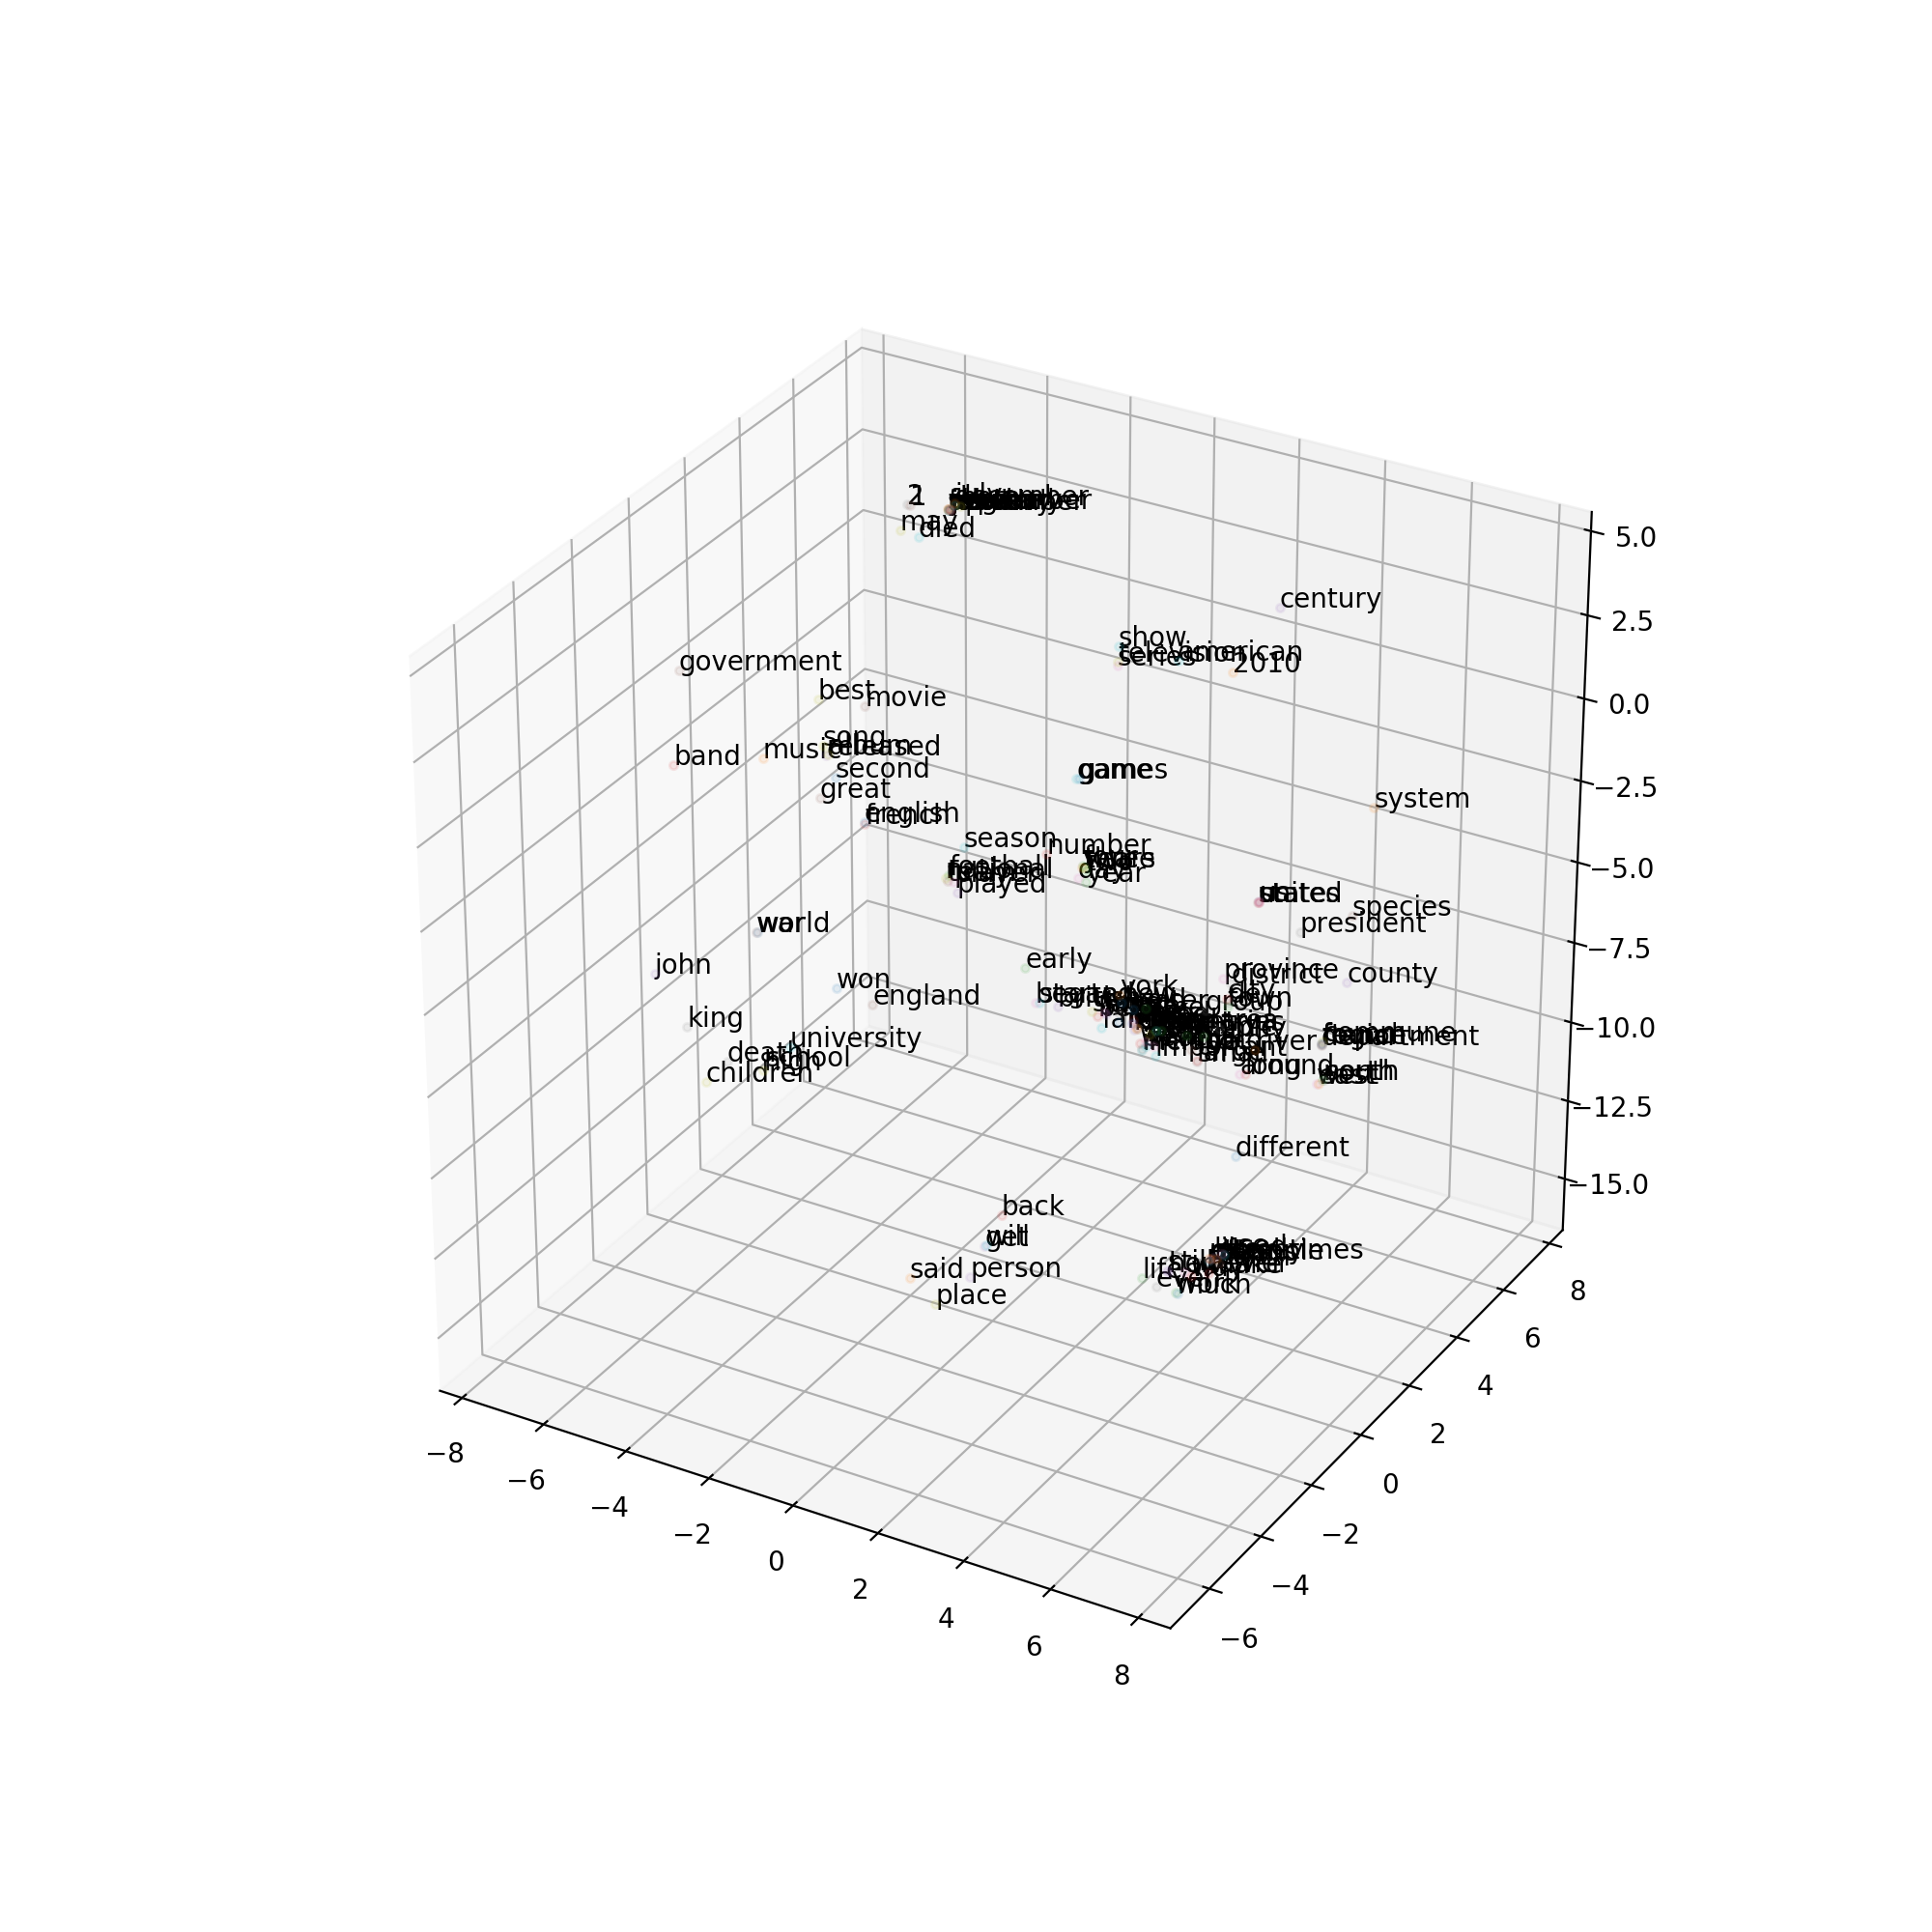

In [99]:
%matplotlib notebook
fig = plt.figure(figsize=(10,10)) 
ax = fig.add_subplot(111, projection="3d")
for i, (label, _) in enumerate(collections.Counter(counter).most_common(150)):
    x, y, z = post_tsne_glove.embedding_[i]
    ax.scatter(x, y, z, s=9, alpha=0.1)
    ax.text(x, y, z, label)


Не вполне ясно, что предлагается из этого выжимать, впрочем. Давайте просто померяем углы:

In [96]:
def angle(s1, w1, s2, w2):
    return np.arccos(cosine_similarity(
        [sum(post_tsne_glove.embedding_[vocab[x]]*sign for sign, x in zip(s1, w1))],
        [sum(post_tsne_glove.embedding_[vocab[x]]*sign for sign, x in zip(s2, w2))],
    ))[0][0]*90/np.pi

In [97]:
angle([1, -1], ["man", "woman"], [1, -1], ["mr", "ms"])

24.130106134111962

Более-менее

In [98]:
angle([1, -1], ["good", "best"], [1, -1], ["bad", "worst"])

14.5222407476104

Тоже неплохо. Без CEO, правда, придётся обойтись --- в словаре их нет почти.

Метрика для сравнения моделей --- количество правильных ответов на вопросы из датасета Миколова:

In [28]:
with open("questions-words.txt") as question_file:
    stops = set(stop_words.get_stop_words(LANG))
    punct = re.compile(r"\p{P}+")

    parsed = (line for line in (tuple(tuple(normalize(line, punct, stops)) for line in question_file.readlines() if not line.startswith(":"))) if len(line) == 4)

    *questions, labels = zip(*parsed)

    questions = list(zip(*questions))

In [37]:
def evaluate(embeds, vocab, questions, labels):
    total = 0
    for i, (label, (pos1, neg, pos2)) in enumerate(zip(labels, questions)):
        if i % 50 == 0:
            print("{}\r".format(i), end="")
        total += (label in set(x[1] for x in analogy([pos1, pos2], [neg], embeds, vocab)))
    return total/len(questions)

In [41]:
evaluate(LSA_embeds, LSA_vocab, questions, labels)

0.08548154258610023

In [39]:
evaluate(w2v_embeds, w2v_vocab, questions, labels)

0.14523613116106412

In [40]:
evaluate(glove_embeds, glove_vocab, questions, labels)

0.06037327283976077

Ну. Могло быть лучше, конечно, но w2v всех обошёл в ~2 раза